# demo_gcfb_v234_speech

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kyama0321/gammachirpy/blob/main/gcfb_v234/demo_gcfb_v234_speech.ipynb)

- Read and analyze a sample speech sound.
- The aumplitude of the input speech sound is normalized by **utils.audioread()**. 
- The output signals of the original dcGC filterbank are saved as a mat-file (.mat).

## Set Up

### For Google Colaboratory Users
- remove comment-out and execute all scripts

In [1]:
#!git clone https://github.com/kyama0321/gammachirpy

In [2]:
#%cd "gammachirpy/gcfb_v234"

### For All Users

In [3]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Audio

import utils
import gcfb_v234 as gcfb

## Set default parameters for the Gammachirp filterbank (GCFB)

In [4]:
class GCparamDefault:
    # --- basic paramters
    fs = 48000 # sampling frequency
    num_ch = 100 # number of channels
    f_range = np.array([100, 6000]) # range of center frequencies
    
    # --- outer & middle ear correlations
    out_mid_crct = "No" # outer & middle ear correlations
    
    # --- time-varying setting
    ctrl = "dynamic" # used to be 'time-varying'
    
    # --- frame-base or sample-base processing
    dyn_hpaf_str_prc = 'frame-base'
    
    # --- hearing-loss patterns and compression health \alpha
    hloss_type = 'NH' # normal hearing listeners

In [5]:
class EMparamDefault:
    # --- basic parameters
    reduce_db = 5 # reduction of TMTF
    f_cutoff = 128 # cutoff frequency of LPF in envelope domation
    fc_mod_list = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256]) # modulation filterbank

## Read a sample speech sound

In [6]:
# stiuli : a sample speech sound
file_name = 'snd_gammachirpy.wav'
path_dir = './sample/'
path_file = path_dir + file_name

# read sample speech
snd, fs = utils.audioread(path_file)
t_snd = len(snd)/fs
t = np.arange(0, len(snd), 1)/fs
print(f"Duration of sound = {t_snd*1000} (ms)")

Duration of sound = 1343.8541666666665 (ms)


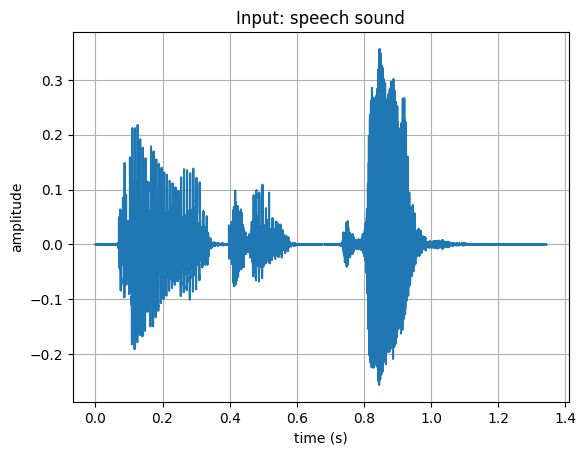

In [7]:
# Plot the input signal
fig, ax = plt.subplots()
ax.plot(t, snd)
ax.set_title("Input: speech sound")
ax.set_xlabel("time (s)")
ax.set_ylabel("amplitude")
plt.grid()

plt.show()

In [8]:
# Play the speech sound
Audio(snd, rate=fs)

## Normal Hearing (NH) Listeners

In [9]:
# Initialize dcGC paramteres for NH
gc_param = GCparamDefault() # reset
gc_param.hloss_type = 'NH' # normal hearing listener

### Input level: 40 dB SPL

In [10]:
# sound pressure level (SPL)
dbspl = 40

# Level equalization: Alternative method v233~
# You can set snd_eq_m precisely if you know SPL (dB) when rms(digital_s(t)) == 1 (i.e., DigitalRms1SPLdB).
digital_rms1_dbspl = 90
snd_digital_level_db = dbspl - digital_rms1_dbspl
snd_src1 = 10**(snd_digital_level_db/20)/utils.rms(snd) * snd
snd_eq_m, _ = utils.eqlz2meddis_hc_level(snd_src1, [], digital_rms1_dbspl)

In [11]:
# dcGC processing
dcgc_out_nh, _, gc_param, gc_resp = gcfb.gcfb_v234(snd_eq_m, gc_param)

*** No Outer/Middle Ear correction ***
*** Gammachirp Calculation ***
--- Channel-by-channel processing ---
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #1 / #100. elapsed time = 0.0 (sec)
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #50 / #100. elapsed time = 0.3 (sec)
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #100 / #100. elapsed time = 0.5 (sec)
--- Frame base processing ---
Frame-based HP-AF: ch #1 / #100.                   elapsed time = 0.1 (sec)
Frame-based HP-AF: ch #50 / #100.                   elapsed time = 2.5 (sec)
Frame-based HP-AF: ch #100 / #100.                   elapsed time = 4.9 (sec)


In [12]:
# load original outputs
name_file = f"./original/GCFBv234_dcGCframe_{gc_param.ctrl}_speech_{gc_param.out_mid_crct}_{dbspl}dBSPL.mat"
gc_out_org = sio.loadmat(name_file)

# cGCout
cgc_out_org = gc_out_org['dcGCframe']
rmse = utils.rms(cgc_out_org - dcgc_out_nh)
print(f'RMSE (cGC): {rmse}')

RMSE (cGC): 4.322878738808511e-15


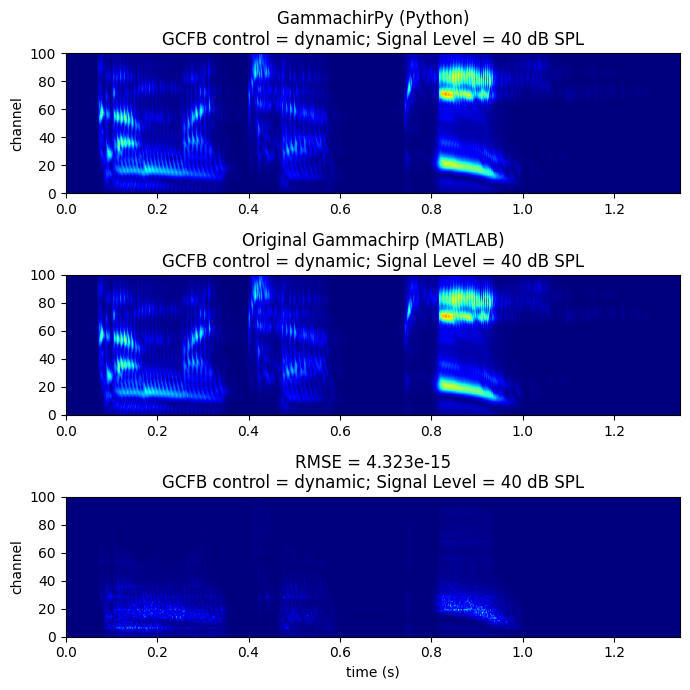

In [13]:
plt.rcParams['figure.figsize'] = (7, 7)

# GammachirPy (Python)
ax = plt.subplot(3, 1, 1)
plt.imshow(np.maximum(dcgc_out_nh, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title("GammachirPy (Python)\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_ylabel("channel")

# Original Gammachirp (MATLAB)
ax = plt.subplot(3, 1, 2)
plt.imshow(np.maximum(cgc_out_org, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title(f"Original Gammachirp (MATLAB)\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")

# RMSE
ax = plt.subplot(3, 1, 3)
error = np.sqrt((cgc_out_org - dcgc_out_nh)**2)
plt.imshow(np.maximum(error, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title(f"RMSE = {rmse:.3e}\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("time (s)")
ax.set_ylabel("channel")

plt.tight_layout()
plt.show()

### Input level: 60 dB SPL

In [14]:
# sound pressure level (SPL)
dbspl = 60

# Level equalization: Alternative method v233~
# You can set snd_eq_m precisely if you know SPL (dB) when rms(digital_s(t)) == 1 (i.e., DigitalRms1SPLdB).
digital_rms1_dbspl = 90
snd_digital_level_db = dbspl - digital_rms1_dbspl
snd_src1 = 10**(snd_digital_level_db/20)/utils.rms(snd) * snd
snd_eq_m, _ = utils.eqlz2meddis_hc_level(snd_src1, [], digital_rms1_dbspl)

In [15]:
# dcGC processing
dcgc_out_nh, _, gc_param, gc_resp = gcfb.gcfb_v234(snd_eq_m, gc_param)

*** No Outer/Middle Ear correction ***
*** Gammachirp Calculation ***
--- Channel-by-channel processing ---
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #1 / #100. elapsed time = 0.0 (sec)
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #50 / #100. elapsed time = 0.3 (sec)
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #100 / #100. elapsed time = 0.5 (sec)
--- Frame base processing ---
Frame-based HP-AF: ch #1 / #100.                   elapsed time = 0.1 (sec)
Frame-based HP-AF: ch #50 / #100.                   elapsed time = 2.6 (sec)
Frame-based HP-AF: ch #100 / #100.                   elapsed time = 5.0 (sec)


In [16]:
# load original outputs
name_file = f"./original/GCFBv234_dcGCframe_{gc_param.ctrl}_speech_{gc_param.out_mid_crct}_{dbspl}dBSPL.mat"
gc_out_org = sio.loadmat(name_file)

# cGCout
cgc_out_org = gc_out_org['dcGCframe']
rmse = utils.rms(cgc_out_org - dcgc_out_nh)
print(f'RMSE (cGC): {rmse}')

RMSE (cGC): 1.5703980649678094e-14


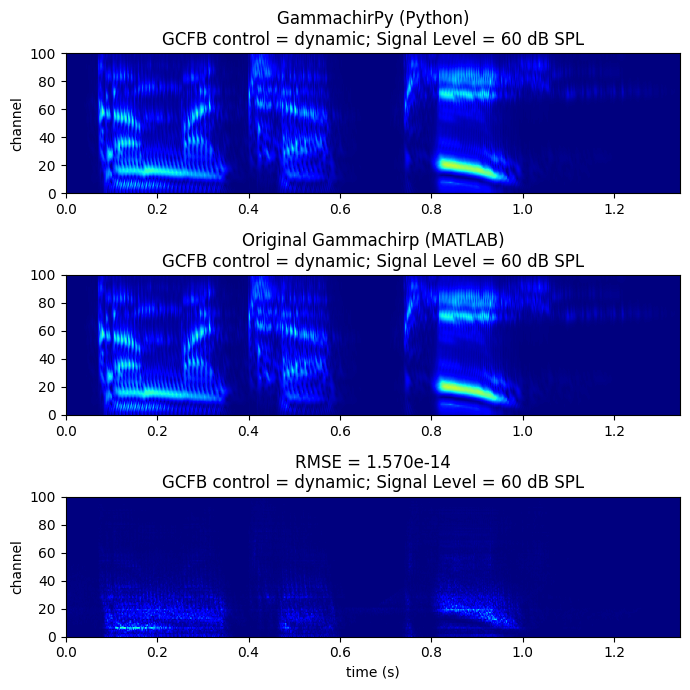

In [17]:
plt.rcParams['figure.figsize'] = (7, 7)

# GammachirPy (Python)
ax = plt.subplot(3, 1, 1)
plt.imshow(np.maximum(dcgc_out_nh, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title("GammachirPy (Python)\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_ylabel("channel")

# Original Gammachirp (MATLAB)
ax = plt.subplot(3, 1, 2)
plt.imshow(np.maximum(cgc_out_org, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title(f"Original Gammachirp (MATLAB)\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")

# RMSE
ax = plt.subplot(3, 1, 3)
error = np.sqrt((cgc_out_org - dcgc_out_nh)**2)
plt.imshow(np.maximum(error, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title(f"RMSE = {rmse:.3e}\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("time (s)")
ax.set_ylabel("channel")

plt.tight_layout()
plt.show()

### Input level: 80 dB SPL

In [18]:
# sound pressure level (SPL)
dbspl = 80

# Level equalization: Alternative method v233~
# You can set snd_eq_m precisely if you know SPL (dB) when rms(digital_s(t)) == 1 (i.e., DigitalRms1SPLdB).
digital_rms1_dbspl = 90
snd_digital_level_db = dbspl - digital_rms1_dbspl
snd_src1 = 10**(snd_digital_level_db/20)/utils.rms(snd) * snd
snd_eq_m, _ = utils.eqlz2meddis_hc_level(snd_src1, [], digital_rms1_dbspl)

In [19]:
# dcGC processing
dcgc_out_nh, _, gc_param, gc_resp = gcfb.gcfb_v234(snd_eq_m, gc_param)

*** No Outer/Middle Ear correction ***
*** Gammachirp Calculation ***
--- Channel-by-channel processing ---
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #1 / #100. elapsed time = 0.0 (sec)
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #50 / #100. elapsed time = 0.3 (sec)
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #100 / #100. elapsed time = 0.5 (sec)
--- Frame base processing ---
Frame-based HP-AF: ch #1 / #100.                   elapsed time = 0.1 (sec)
Frame-based HP-AF: ch #50 / #100.                   elapsed time = 2.4 (sec)
Frame-based HP-AF: ch #100 / #100.                   elapsed time = 4.8 (sec)


In [20]:
# load original outputs
name_file = f"./original/GCFBv234_dcGCframe_{gc_param.ctrl}_speech_{gc_param.out_mid_crct}_{dbspl}dBSPL.mat"
gc_out_org = sio.loadmat(name_file)

# cGCout
cgc_out_org = gc_out_org['dcGCframe']
rmse = utils.rms(cgc_out_org - dcgc_out_nh)
print(f'RMSE (cGC): {rmse}')

RMSE (cGC): 6.453195117346911e-14


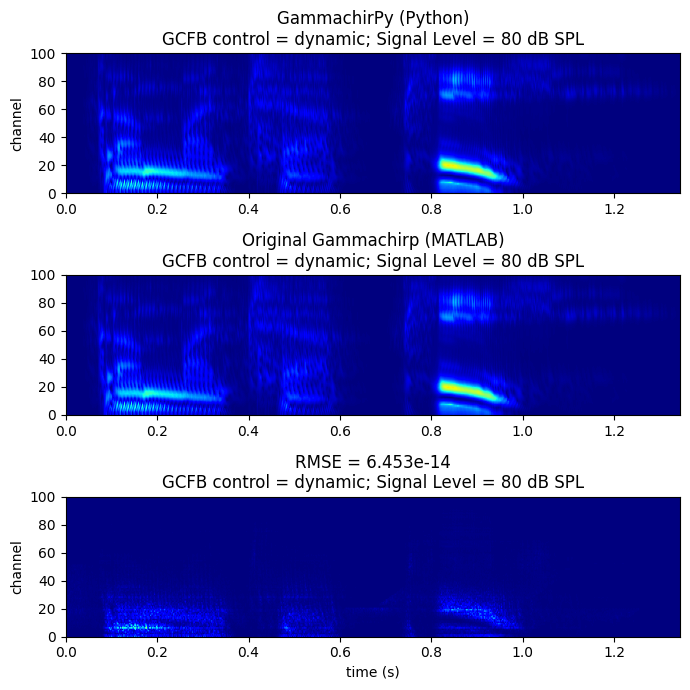

In [21]:
plt.rcParams['figure.figsize'] = (7, 7)

# GammachirPy (Python)
ax = plt.subplot(3, 1, 1)
plt.imshow(np.maximum(dcgc_out_nh, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title("GammachirPy (Python)\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_ylabel("channel")

# Original Gammachirp (MATLAB)
ax = plt.subplot(3, 1, 2)
plt.imshow(np.maximum(cgc_out_org, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title(f"Original Gammachirp (MATLAB)\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")

# RMSE
ax = plt.subplot(3, 1, 3)
error = np.sqrt((cgc_out_org - dcgc_out_nh)**2)
plt.imshow(np.maximum(error, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title(f"RMSE = {rmse:.3e}\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("time (s)")
ax.set_ylabel("channel")

plt.tight_layout()
plt.show()

## HL3: Hearing loss listener

In [22]:
# Initialize dcGC paramteres for HL
gc_param_hl = GCparamDefault() # reset
gc_param_hl.hloss_type = 'HL3'
gc_param_hl.hloss_compression_health = 0.5

# Initialize EM paramteres
em_param = EMparamDefault()

### Input level: 40 dB SPL

In [23]:
# sound pressure level (SPL)
dbspl = 40

# Level equalization: Alternative method v233~
# You can set snd_eq_m precisely if you know SPL (dB) when rms(digital_s(t)) == 1 (i.e., DigitalRms1SPLdB).
digital_rms1_dbspl = 90
snd_digital_level_db = dbspl - digital_rms1_dbspl
snd_src1 = 10**(snd_digital_level_db/20)/utils.rms(snd) * snd
snd_eq_m, _ = utils.eqlz2meddis_hc_level(snd_src1, [], digital_rms1_dbspl)

In [24]:
# dcGC processing
dcgc_out_hl3, _, gc_param, gc_resp = gcfb.gcfb_v234(snd_eq_m, gc_param_hl)

*** No Outer/Middle Ear correction ***
*** Gammachirp Calculation ***
--- Channel-by-channel processing ---
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #1 / #100. elapsed time = 0.0 (sec)
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #50 / #100. elapsed time = 0.4 (sec)
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #100 / #100. elapsed time = 0.6 (sec)
--- Frame base processing ---
Frame-based HP-AF: ch #1 / #100.                   elapsed time = 0.1 (sec)
Frame-based HP-AF: ch #50 / #100.                   elapsed time = 2.5 (sec)
Frame-based HP-AF: ch #100 / #100.                   elapsed time = 5.5 (sec)


In [25]:
# load original outputs
name_file = f"./original/GCFBv234_dcGCframeHL_{gc_param.ctrl}_speech_{gc_param.out_mid_crct}_{dbspl}dBSPL.mat"
gc_out_org = sio.loadmat(name_file)

# cGCout
cgc_out_org = gc_out_org['dcGCframeHL']
rmse = utils.rms(cgc_out_org - dcgc_out_hl3)
print(f'RMSE (cGC): {rmse}')

RMSE (cGC): 2.3711510722939887e-15


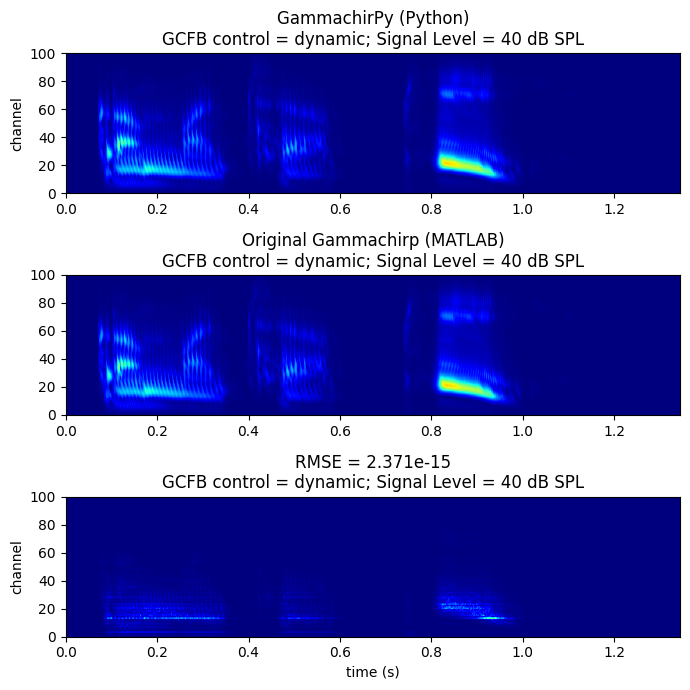

In [26]:
plt.rcParams['figure.figsize'] = (7, 7)

# GammachirPy (Python)
ax = plt.subplot(3, 1, 1)
plt.imshow(np.maximum(dcgc_out_hl3, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title("GammachirPy (Python)\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_ylabel("channel")

# Original Gammachirp (MATLAB)
ax = plt.subplot(3, 1, 2)
plt.imshow(np.maximum(cgc_out_org, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title(f"Original Gammachirp (MATLAB)\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")

# RMSE
ax = plt.subplot(3, 1, 3)
error = np.sqrt((cgc_out_org - dcgc_out_hl3)**2)
plt.imshow(np.maximum(error, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title(f"RMSE = {rmse:.3e}\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("time (s)")
ax.set_ylabel("channel")

plt.tight_layout()
plt.show()

### Input level: 60 dB SPL

In [27]:
# sound pressure level (SPL)
dbspl = 60

# Level equalization: Alternative method v233~
# You can set snd_eq_m precisely if you know SPL (dB) when rms(digital_s(t)) == 1 (i.e., DigitalRms1SPLdB).
digital_rms1_dbspl = 90
snd_digital_level_db = dbspl - digital_rms1_dbspl
snd_src1 = 10**(snd_digital_level_db/20)/utils.rms(snd) * snd
snd_eq_m, _ = utils.eqlz2meddis_hc_level(snd_src1, [], digital_rms1_dbspl)

In [28]:
# dcGC processing
dcgc_out_hl3, _, gc_param, gc_resp = gcfb.gcfb_v234(snd_eq_m, gc_param_hl)

*** No Outer/Middle Ear correction ***
*** Gammachirp Calculation ***
--- Channel-by-channel processing ---
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #1 / #100. elapsed time = 0.0 (sec)
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #50 / #100. elapsed time = 0.4 (sec)
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #100 / #100. elapsed time = 0.6 (sec)
--- Frame base processing ---
Frame-based HP-AF: ch #1 / #100.                   elapsed time = 0.1 (sec)
Frame-based HP-AF: ch #50 / #100.                   elapsed time = 2.7 (sec)
Frame-based HP-AF: ch #100 / #100.                   elapsed time = 5.9 (sec)


In [29]:
# load original outputs
name_file = f"./original/GCFBv234_dcGCframeHL_{gc_param.ctrl}_speech_{gc_param.out_mid_crct}_{dbspl}dBSPL.mat"
gc_out_org = sio.loadmat(name_file)

# cGCout
cgc_out_org = gc_out_org['dcGCframeHL']
rmse = utils.rms(cgc_out_org - dcgc_out_hl3)
print(f'RMSE (cGC): {rmse}')

RMSE (cGC): 1.0904758127338006e-14


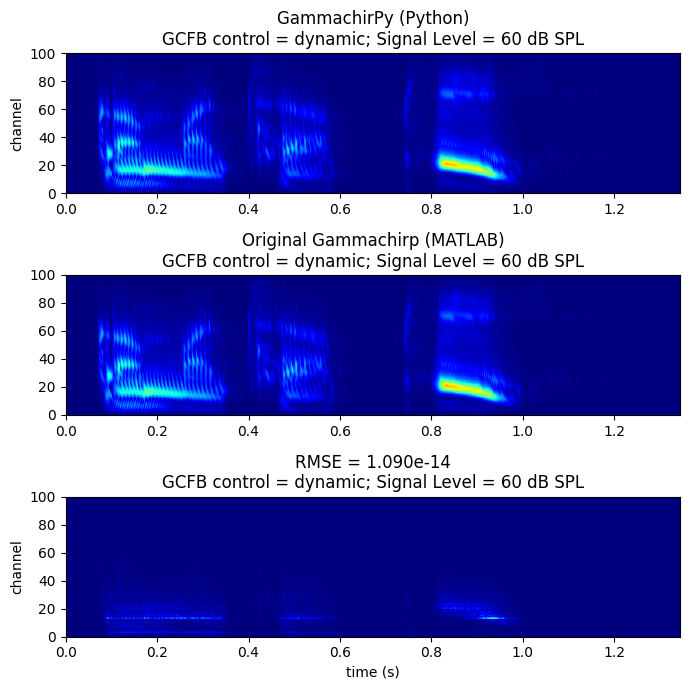

In [30]:
plt.rcParams['figure.figsize'] = (7, 7)

# GammachirPy (Python)
ax = plt.subplot(3, 1, 1)
plt.imshow(np.maximum(dcgc_out_hl3, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title("GammachirPy (Python)\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_ylabel("channel")

# Original Gammachirp (MATLAB)
ax = plt.subplot(3, 1, 2)
plt.imshow(np.maximum(cgc_out_org, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title(f"Original Gammachirp (MATLAB)\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")

# RMSE
ax = plt.subplot(3, 1, 3)
error = np.sqrt((cgc_out_org - dcgc_out_hl3)**2)
plt.imshow(np.maximum(error, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title(f"RMSE = {rmse:.3e}\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("time (s)")
ax.set_ylabel("channel")

plt.tight_layout()
plt.show()

### Input level: 80 dB SPL

In [31]:
# sound pressure level (SPL)
dbspl = 80

# Level equalization: Alternative method v233~
# You can set snd_eq_m precisely if you know SPL (dB) when rms(digital_s(t)) == 1 (i.e., DigitalRms1SPLdB).
digital_rms1_dbspl = 90
snd_digital_level_db = dbspl - digital_rms1_dbspl
snd_src1 = 10**(snd_digital_level_db/20)/utils.rms(snd) * snd
snd_eq_m, _ = utils.eqlz2meddis_hc_level(snd_src1, [], digital_rms1_dbspl)

In [32]:
# dcGC processing
dcgc_out_hl3, _, gc_param, gc_resp = gcfb.gcfb_v234(snd_eq_m, gc_param_hl)

*** No Outer/Middle Ear correction ***
*** Gammachirp Calculation ***
--- Channel-by-channel processing ---
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #1 / #100. elapsed time = 0.0 (sec)
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #50 / #100. elapsed time = 0.3 (sec)
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #100 / #100. elapsed time = 0.6 (sec)
--- Frame base processing ---
Frame-based HP-AF: ch #1 / #100.                   elapsed time = 0.1 (sec)
Frame-based HP-AF: ch #50 / #100.                   elapsed time = 3.1 (sec)
Frame-based HP-AF: ch #100 / #100.                   elapsed time = 5.8 (sec)


In [33]:
# load original outputs
name_file = f"./original/GCFBv234_dcGCframeHL_{gc_param.ctrl}_speech_{gc_param.out_mid_crct}_{dbspl}dBSPL.mat"
gc_out_org = sio.loadmat(name_file)

# cGCout
cgc_out_org = gc_out_org['dcGCframeHL']
rmse = utils.rms(cgc_out_org - dcgc_out_hl3)
print(f'RMSE (cGC): {rmse}')

RMSE (cGC): 5.528696210714278e-14


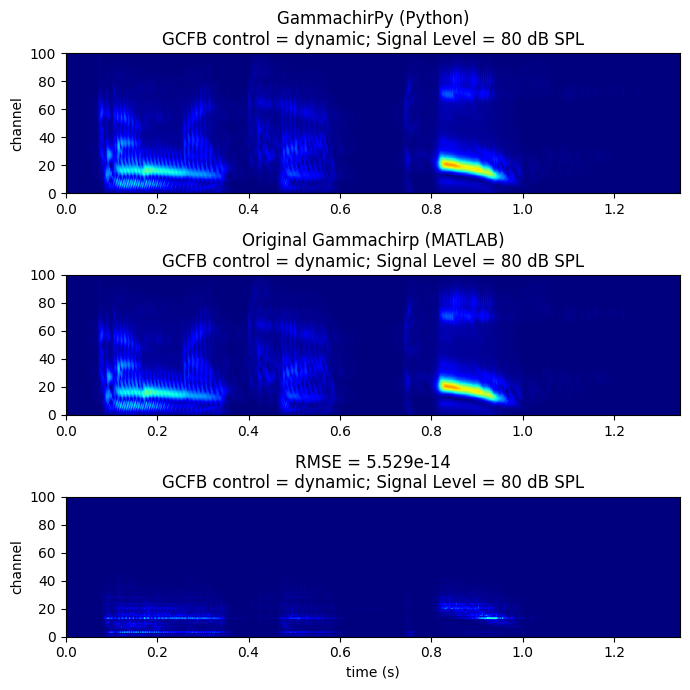

In [34]:
plt.rcParams['figure.figsize'] = (7, 7)

# GammachirPy (Python)
ax = plt.subplot(3, 1, 1)
plt.imshow(np.maximum(dcgc_out_hl3, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title("GammachirPy (Python)\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_ylabel("channel")

# Original Gammachirp (MATLAB)
ax = plt.subplot(3, 1, 2)
plt.imshow(np.maximum(cgc_out_org, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title(f"Original Gammachirp (MATLAB)\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")

# RMSE
ax = plt.subplot(3, 1, 3)
error = np.sqrt((cgc_out_org - dcgc_out_hl3)**2)
plt.imshow(np.maximum(error, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title(f"RMSE = {rmse:.3e}\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("time (s)")
ax.set_ylabel("channel")

plt.tight_layout()
plt.show()

## HL3 + TMTF reduction

In [35]:
# Initialize dcGC paramteres for HL
gc_param_hl = GCparamDefault() # reset
gc_param_hl.hloss_type = 'HL3'
gc_param_hl.hloss_compression_health = 0.5

# Initialize EM paramteres
em_param = EMparamDefault()

### Input level: 40 dB SPL

In [36]:
# sound pressure level (SPL)
dbspl = 40

# Level equalization: Alternative method v233~
# You can set snd_eq_m precisely if you know SPL (dB) when rms(digital_s(t)) == 1 (i.e., DigitalRms1SPLdB).
digital_rms1_dbspl = 90
snd_digital_level_db = dbspl - digital_rms1_dbspl
snd_src1 = 10**(snd_digital_level_db/20)/utils.rms(snd) * snd
snd_eq_m, _ = utils.eqlz2meddis_hc_level(snd_src1, [], digital_rms1_dbspl)

In [37]:
# dcGC processing
dcgc_out_hl3, _, gc_param_hl3, gc_resp_hl3 = gcfb.gcfb_v234(snd_eq_m, gc_param_hl)

# EM loss processing
gcem_loss, em_param = gcfb.gcfb_v23_env_mod_loss(dcgc_out_hl3, gc_param_hl3, em_param)
gcem_frame, em_param = gcfb.gcfb_v23_ana_env_mod(dcgc_out_hl3, gc_param_hl3, em_param)

*** No Outer/Middle Ear correction ***
*** Gammachirp Calculation ***
--- Channel-by-channel processing ---
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #1 / #100. elapsed time = 0.0 (sec)
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #50 / #100. elapsed time = 0.3 (sec)
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #100 / #100. elapsed time = 0.6 (sec)
--- Frame base processing ---
Frame-based HP-AF: ch #1 / #100.                   elapsed time = 0.1 (sec)
Frame-based HP-AF: ch #50 / #100.                   elapsed time = 3.0 (sec)
Frame-based HP-AF: ch #100 / #100.                   elapsed time = 6.1 (sec)


In [38]:
# load original outputs
name_file = f"./original/GCFBv234_GCEMLoss_{gc_param.ctrl}_speech_{gc_param.out_mid_crct}_{dbspl}dBSPL.mat"
gc_out_org = sio.loadmat(name_file)

# cGCout
cgc_out_org = gc_out_org['GCEMLoss']
rmse = utils.rms(cgc_out_org - gcem_loss)
print(f'RMSE (cGC): {rmse}')

RMSE (cGC): 7.380703987446336e-16


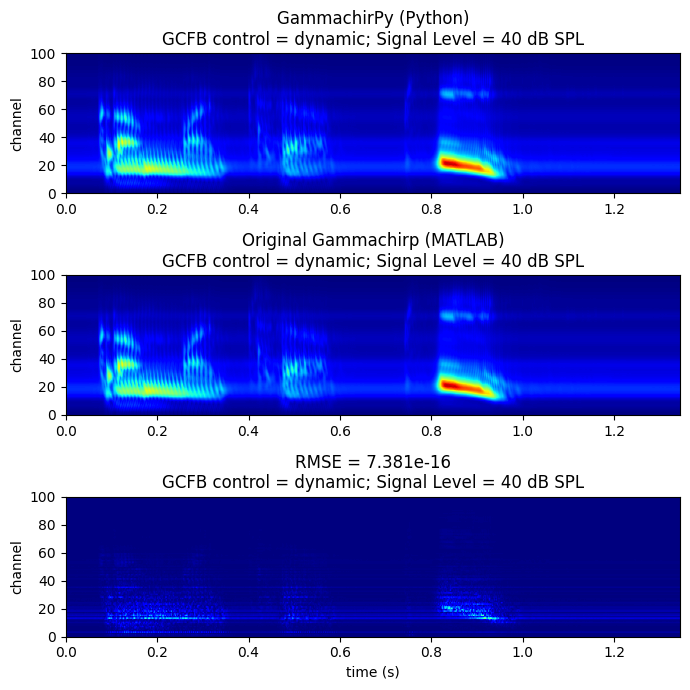

In [39]:
plt.rcParams['figure.figsize'] = (7, 7)

# GammachirPy (Python)
ax = plt.subplot(3, 1, 1)
plt.imshow(np.maximum(gcem_loss, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title("GammachirPy (Python)\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_ylabel("channel")

# Original Gammachirp (MATLAB)
ax = plt.subplot(3, 1, 2)
plt.imshow(np.maximum(cgc_out_org, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title(f"Original Gammachirp (MATLAB)\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_ylabel("channel")

# RMSE
ax = plt.subplot(3, 1, 3)
error = np.sqrt((cgc_out_org - gcem_loss)**2)
plt.imshow(np.maximum(error, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title(f"RMSE = {rmse:.3e}\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("time (s)")
ax.set_ylabel("channel")

plt.tight_layout()
plt.show()

### Input level: 60 dB SPL

In [40]:
# sound pressure level (SPL)
dbspl = 60

# Level equalization: Alternative method v233~
# You can set snd_eq_m precisely if you know SPL (dB) when rms(digital_s(t)) == 1 (i.e., DigitalRms1SPLdB).
digital_rms1_dbspl = 90
snd_digital_level_db = dbspl - digital_rms1_dbspl
snd_src1 = 10**(snd_digital_level_db/20)/utils.rms(snd) * snd
snd_eq_m, _ = utils.eqlz2meddis_hc_level(snd_src1, [], digital_rms1_dbspl)

In [41]:
# dcGC processing
dcgc_out_hl3, _, gc_param_hl3, gc_resp_hl3 = gcfb.gcfb_v234(snd_eq_m, gc_param_hl)

# EM loss processing
gcem_loss, em_param = gcfb.gcfb_v23_env_mod_loss(dcgc_out_hl3, gc_param_hl3, em_param)
gcem_frame, em_param = gcfb.gcfb_v23_ana_env_mod(dcgc_out_hl3, gc_param_hl3, em_param)

*** No Outer/Middle Ear correction ***
*** Gammachirp Calculation ***
--- Channel-by-channel processing ---
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #1 / #100. elapsed time = 0.0 (sec)
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #50 / #100. elapsed time = 0.3 (sec)
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #100 / #100. elapsed time = 0.6 (sec)
--- Frame base processing ---
Frame-based HP-AF: ch #1 / #100.                   elapsed time = 0.1 (sec)
Frame-based HP-AF: ch #50 / #100.                   elapsed time = 2.9 (sec)
Frame-based HP-AF: ch #100 / #100.                   elapsed time = 5.5 (sec)


In [42]:
# load original outputs
name_file = f"./original/GCFBv234_GCEMLoss_{gc_param.ctrl}_speech_{gc_param.out_mid_crct}_{dbspl}dBSPL.mat"
gc_out_org = sio.loadmat(name_file)

# cGCout
cgc_out_org = gc_out_org['GCEMLoss']
rmse = utils.rms(cgc_out_org - gcem_loss)
print(f'RMSE (cGC): {rmse}')

RMSE (cGC): 3.5704646909653985e-15


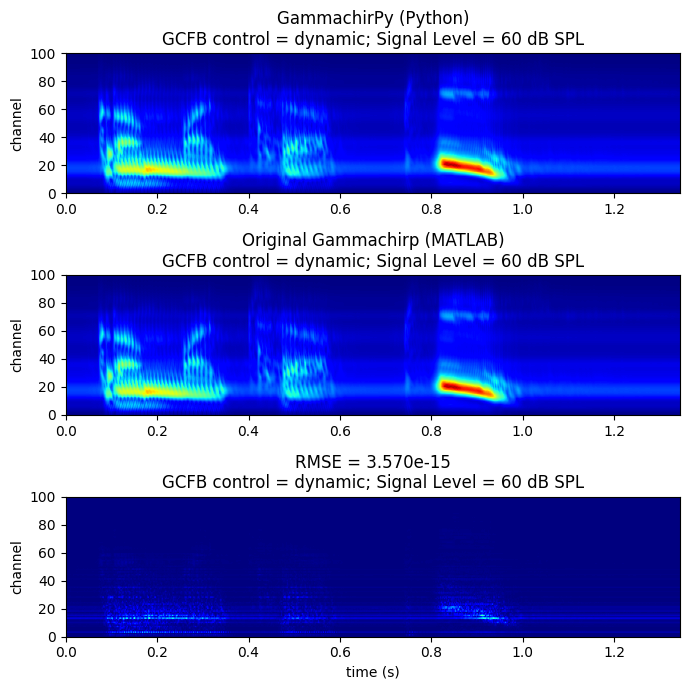

In [43]:
plt.rcParams['figure.figsize'] = (7, 7)

# GammachirPy (Python)
ax = plt.subplot(3, 1, 1)
plt.imshow(np.maximum(gcem_loss, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title("GammachirPy (Python)\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_ylabel("channel")

# Original Gammachirp (MATLAB)
ax = plt.subplot(3, 1, 2)
plt.imshow(np.maximum(cgc_out_org, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title(f"Original Gammachirp (MATLAB)\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_ylabel("channel")

# RMSE
ax = plt.subplot(3, 1, 3)
error = np.sqrt((cgc_out_org - gcem_loss)**2)
plt.imshow(np.maximum(error, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title(f"RMSE = {rmse:.3e}\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("time (s)")
ax.set_ylabel("channel")

plt.tight_layout()
plt.show()

### Input level: 80 dB SPL

In [44]:
# sound pressure level (SPL)
dbspl = 80

# Level equalization: Alternative method v233~
# You can set snd_eq_m precisely if you know SPL (dB) when rms(digital_s(t)) == 1 (i.e., DigitalRms1SPLdB).
digital_rms1_dbspl = 90
snd_digital_level_db = dbspl - digital_rms1_dbspl
snd_src1 = 10**(snd_digital_level_db/20)/utils.rms(snd) * snd
snd_eq_m, _ = utils.eqlz2meddis_hc_level(snd_src1, [], digital_rms1_dbspl)

In [45]:
# dcGC processing
dcgc_out_hl3, _, gc_param_hl3, gc_resp_hl3 = gcfb.gcfb_v234(snd_eq_m, gc_param_hl)

# EM loss processing
gcem_loss, em_param = gcfb.gcfb_v23_env_mod_loss(dcgc_out_hl3, gc_param_hl3, em_param)
gcem_frame, em_param = gcfb.gcfb_v23_ana_env_mod(dcgc_out_hl3, gc_param_hl3, em_param)

*** No Outer/Middle Ear correction ***
*** Gammachirp Calculation ***
--- Channel-by-channel processing ---
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #1 / #100. elapsed time = 0.0 (sec)
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #50 / #100. elapsed time = 0.3 (sec)
Passive-Gammachirp*Fixed HP-AF = Level estimation filter
ch #100 / #100. elapsed time = 0.6 (sec)
--- Frame base processing ---
Frame-based HP-AF: ch #1 / #100.                   elapsed time = 0.1 (sec)
Frame-based HP-AF: ch #50 / #100.                   elapsed time = 3.1 (sec)
Frame-based HP-AF: ch #100 / #100.                   elapsed time = 5.6 (sec)


In [46]:
# load original outputs
name_file = f"./original/GCFBv234_GCEMLoss_{gc_param.ctrl}_speech_{gc_param.out_mid_crct}_{dbspl}dBSPL.mat"
gc_out_org = sio.loadmat(name_file)

# cGCout
cgc_out_org = gc_out_org['GCEMLoss']
rmse = utils.rms(cgc_out_org - gcem_loss)
print(f'RMSE (cGC): {rmse}')

RMSE (cGC): 1.860745711576554e-14


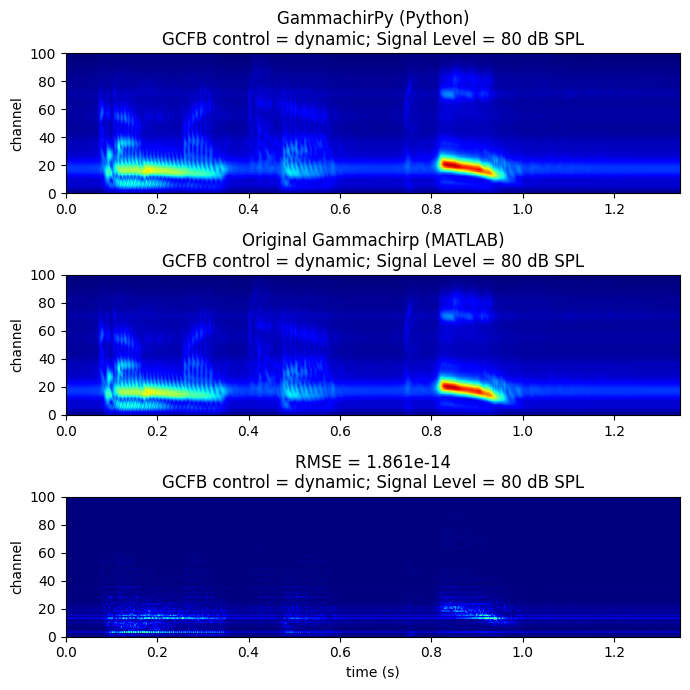

In [47]:
plt.rcParams['figure.figsize'] = (7, 7)

# GammachirPy (Python)
ax = plt.subplot(3, 1, 1)
plt.imshow(np.maximum(gcem_loss, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title("GammachirPy (Python)\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_ylabel("channel")

# Original Gammachirp (MATLAB)
ax = plt.subplot(3, 1, 2)
plt.imshow(np.maximum(cgc_out_org, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title(f"Original Gammachirp (MATLAB)\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_ylabel("channel")

# RMSE
ax = plt.subplot(3, 1, 3)
error = np.sqrt((cgc_out_org - gcem_loss)**2)
plt.imshow(np.maximum(error, 0), \
    extent=[min(t), max(t), 0, 100], aspect='auto', origin='lower', cmap='jet')
ax.set_title(f"RMSE = {rmse:.3e}\n" \
               + f"GCFB control = {gc_param.ctrl}; Signal Level = {dbspl} dB SPL")
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("time (s)")
ax.set_ylabel("channel")

plt.tight_layout()
plt.show()